# Entraînement Avancé du Modèle LightGBM\n
\n
Ce notebook met en œuvre l'entraînement du modèle LightGBM avec une **optimisation avancée des hyperparamètres**.\n
\n
Méthodologie :\n
1. **Chargement et Préparation** : Conversion des variables catégorielles.\n
2. **Optimisation Optuna** : Recherche des meilleurs hyperparamètres.\n
3. **Validation Croisée Temporelle** : `TimeSeriesSplit` pour évaluer chaque essai de manière robuste sans fuite de données futures.\n
4. **Entraînement Final** : Utilisation des meilleurs paramètres sur l'ensemble d'entraînement complet.\n
5. **Évaluation** : Test sur l'ensemble de test dédié.\n

In [1]:
import sys
!{sys.executable} -m pip install optuna --break-system-packages

import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import os
import pickle
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.INFO)

# Dossier de sortie
os.makedirs('trained_models', exist_ok=True)

Defaulting to user installation because normal site-packages is not writeable
  Using cached greenlet-3.3.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 5.0 MB/s eta 0:00:00
Using cached greenlet-3.3.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (609 kB)


/home/raph/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Chargement et Préparation des Données

In [2]:
# Chemins des fichiers
train_X_path = 'donnees_pretraitees/X_train_7_jours.csv'
train_y_path = 'donnees_pretraitees/y_train_7_jours.csv'
test_X_path = 'donnees_pretraitees/X_test_7_jours.csv'
test_y_path = 'donnees_pretraitees/y_test_7_jours.csv'

# Chargement
X_train = pd.read_csv(train_X_path)
y_train = pd.read_csv(train_y_path)
X_test = pd.read_csv(test_X_path)
y_test = pd.read_csv(test_y_path)

# Formatage des cibles
if y_train.shape[1] == 1: y_train = y_train.iloc[:, 0]
if y_test.shape[1] == 1: y_test = y_test.iloc[:, 0]

# Conversion des catégories
cat_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality']
for col in cat_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (56000, 65), Test shape: (14100, 65)


## 2. Optimisation avec Optuna et Validation Croisée Temporelle

In [3]:
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    # TimeSeriesSplit pour éviter la fuite de données (le futur prédit le passé)
    tscv = TimeSeriesSplit(n_splits=3)
    rmse_scores = []

    for train_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

        model = lgb.train(
            param, 
            dtrain, 
            valid_sets=[dval], 
            callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
        )
        
        preds = model.predict(X_val, num_iteration=model.best_iteration)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Lancement de l'étude d'optimisation
study = optuna.create_study(direction='minimize')
print("Début de l'optimisation des hyperparamètres...")
study.optimize(objective, n_trials=20)  # 20 itérations pour commencer, ajuster si besoin

print("\nMeilleurs hyperparamètres :")
print(study.best_params)

[I 2026-01-05 17:52:01,297] A new study created in memory with name: no-name-a44b01ee-7a9f-4ac6-af20-e9beb93467d6


Début de l'optimisation des hyperparamètres...


[I 2026-01-05 17:52:03,748] Trial 0 finished with value: 109.18456737542834 and parameters: {'num_leaves': 78, 'learning_rate': 0.08538735751212587, 'feature_fraction': 0.6382504014326134, 'bagging_fraction': 0.5491965549777167, 'bagging_freq': 2, 'lambda_l1': 2.5472899004891165e-07, 'lambda_l2': 6.3219232515842225e-06, 'min_child_samples': 70}. Best is trial 0 with value: 109.18456737542834.
[I 2026-01-05 17:52:05,691] Trial 1 finished with value: 109.16572567326274 and parameters: {'num_leaves': 95, 'learning_rate': 0.04829622640906473, 'feature_fraction': 0.6634065229126651, 'bagging_fraction': 0.501610467250407, 'bagging_freq': 6, 'lambda_l1': 0.0470684035752404, 'lambda_l2': 1.7630581756828697e-05, 'min_child_samples': 85}. Best is trial 1 with value: 109.16572567326274.
[I 2026-01-05 17:52:07,500] Trial 2 finished with value: 109.31611405469216 and parameters: {'num_leaves': 78, 'learning_rate': 0.25303817621406655, 'feature_fraction': 0.7366716097454364, 'bagging_fraction': 0.74


Meilleurs hyperparamètres :
{'num_leaves': 99, 'learning_rate': 0.01966847846601687, 'feature_fraction': 0.4202053022127381, 'bagging_fraction': 0.611396337774306, 'bagging_freq': 7, 'lambda_l1': 0.006511970200273135, 'lambda_l2': 6.131169976889974e-05, 'min_child_samples': 100}


## 3. Entraînement Final et Évaluation

In [4]:
# Récupération des meilleurs paramètres
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['random_state'] = 42
best_params['verbose'] = -1

print("Entraînement du modèle final avec les meilleurs paramètres...")
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

final_model = lgb.train(
    best_params,
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

# Prédictions
predictions = final_model.predict(X_test, num_iteration=final_model.best_iteration)

# Métriques
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print(f"\nRésultats Finaux sur Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Sauvegarde
model_path = 'trained_models/lightgbm_model_optimized.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

with open('trained_models/lightgbm_metrics_optimized.txt', 'w') as f:
    f.write(f"RMSE: {rmse}\nMAE: {mae}\nBest Params: {best_params}")

print(f"Modèle optimisé sauvegardé : {model_path}")

Entraînement du modèle final avec les meilleurs paramètres...
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 109.037
Early stopping, best iteration is:
[2]	valid_0's rmse: 108.983

Résultats Finaux sur Test Set:
RMSE: 108.9826
MAE: 89.2983
Modèle optimisé sauvegardé : trained_models/lightgbm_model_optimized.pkl


## 4. Visualisation

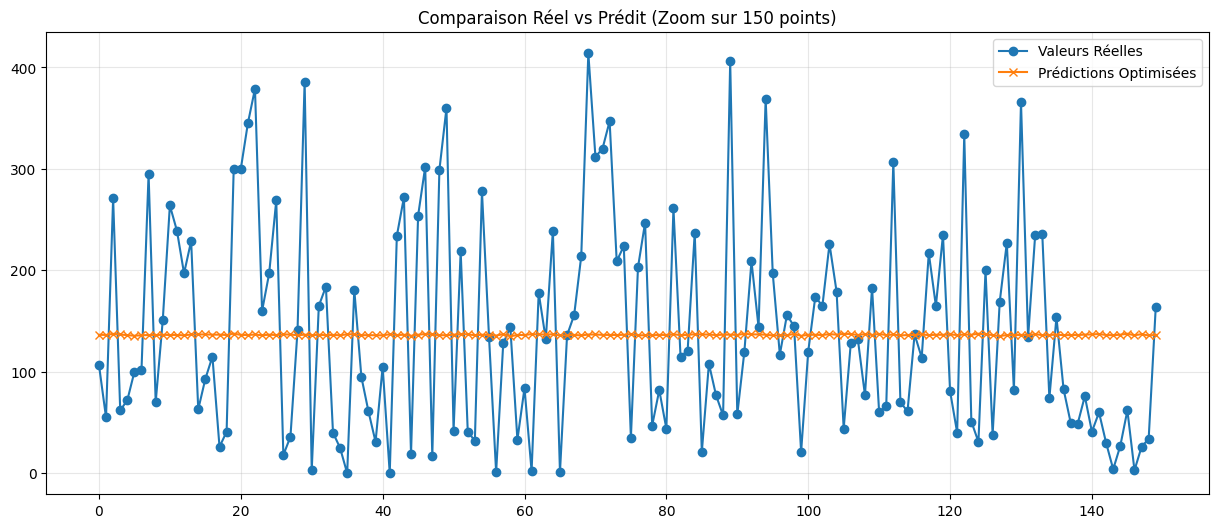

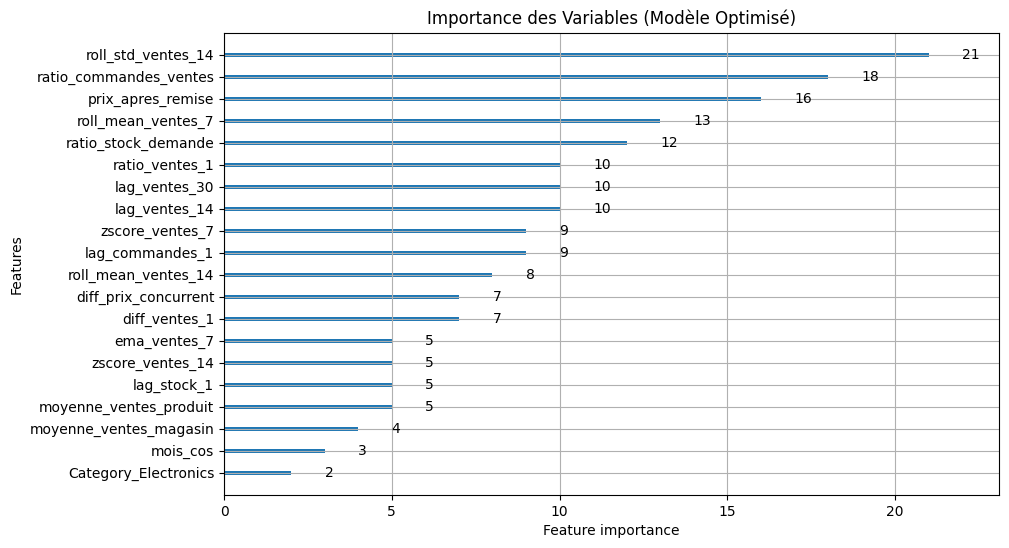

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:150], label='Valeurs Réelles', marker='o')
plt.plot(predictions[:150], label='Prédictions Optimisées', marker='x')
plt.title('Comparaison Réel vs Prédit (Zoom sur 150 points)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

lgb.plot_importance(final_model, max_num_features=20, figsize=(10, 6))
plt.title("Importance des Variables (Modèle Optimisé)")
plt.show()